# **Instacart Market Basket Analysis** 

##              CLASSIFICATION


## Method
Our method includes the following steps:
1. <b>Import and reshape data</b>: This step includes loading CSV files into pandas DataFrames, tranform character variables to categorical variables, and create a supportive table.
2. <b>Create predictor variables</b>: This step includes identifying and calculating predictor variables (aka features) from the initial datasets provided by Instacart. 
3. <b>Create train and test DataFrames</b>: In this step we create two distinct pandas DataFrames that will be used in the creation and the use of the predictive model.
4. <b>Create predictive model (fit)</b>: In this step we train a predictive model through the train dataset.
5. <b>Apply predictive model (predict)</b>: This step includes applying the model to predict the 'reordered' variable for the test dataset.
6. <b>Get F1 score</b>: In this step we submit the produced and file and get the F1 score describing the accuracy of our prediction model.

# 1. Import Data 
First we load the necessary Python packages and then we import the CSV files that were provided by Instacart.
Package import is as per requirement 
##Import the required packages


In [0]:
# For data manipulation
import pandas as pd        
# Garbage Collector to free up memory
import gc                         
gc.enable()  # Activate 

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/DM_proj/DM_proj/DM_Project_code/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load data from the CSV files
We have provides 6 CSV files, 

In [0]:
orders = pd.read_csv(path + 'orders.csv' )
order_products_train = pd.read_csv(path + 'order_products__train.csv')
order_products_prior = pd.read_csv(path + 'order_products__prior.csv')
products = pd.read_csv(path + 'products.csv')
aisles = pd.read_csv(path + 'aisles.csv')
departments = pd.read_csv(path + 'departments.csv')

## We created a dataframe combining orders and products based on order_products_prior

In [4]:
#Merge the orders DF with order_products_prior by their order_id, keep only these rows with order_id that they are appear on both DFs
df_op = orders.merge(order_products_prior, on='order_id', how='inner') ##
df_op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


# 2. Create Predictor Variables
Predictor variables are used for predicting the reorder 
* <b>User predictors</b> describing the behavior of a user e.g. total number of orders of a user.
* <b>Product predictors</b> describing characteristics of a product e.g. total number of times a product has been purchased.
* <b>User & product predictors</b> describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.

## A -  Create user predictors



### 1. Number of orders per customer


In [5]:
# Create distinct groups for each user, identify the highest order number in each group, save the new column to a DataFrame
user_opc = df_op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
user_opc.head()


,u_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [6]:
# Reset the index of the DF so to bring user_id from index to column (pre-requisite for step 2.4)
user_opc = user_opc.reset_index()
user_opc.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


### 2. How frequent a customer has reordered products


In [7]:
user_reorder = df_op.groupby('user_id')['reordered'].mean().to_frame('user_reordered_ratio') #
user_reorder = user_reorder.reset_index()
user_reorder.head()

,user_id,user_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [8]:
user_opc = user_opc.merge(user_reorder, on='user_id', how='left') #

del user_reorder
gc.collect()

user_opc.head()

,user_id,u_total_orders,user_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


## B - Create product predictors

### 1. Number of purchases for each product


In [9]:
# Create distinct groups for each product, count the orders, save the result for each product to a new DataFrame  
prod = df_op.groupby('product_id')['order_id'].count().to_frame('prod_total_purchases')
prod.head()

,prod_total_purchases
product_id,
1,1852
2,90
3,277
4,329
5,15


In [10]:
# Reset the index of the DF so to bring product_id rom index to column (pre-requisite for step 2.4)
prod = prod.reset_index()
prod.head()

,product_id,prod_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


## 2. What is the probability for a product to be reordered



In [11]:
# the x on lambda function is a temporary variable which represents each group
# shape[0] on a DataFrame returns the number of rows
prod_reorder = df_op.groupby('product_id').filter(lambda x: x.shape[0] >40)
prod_reorder.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


###  Group products, calculate the mean of reorders

When reorder column is 1 then the user has reordered, probablity of reorder will be calculated using mean()


In [12]:
prod_reorder = prod_reorder.groupby('product_id')['reordered'].mean().to_frame('prod_reorder_ratio')
prod_reorder = prod_reorder.reset_index()
prod_reorder.head()

,product_id,prod_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030


### Merge the new feature on prd DataFrame


In [13]:
#Merge the prd DataFrame with reorder
prod = prod.merge(prod_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del prod_reorder
gc.collect()

prod.head()

,product_id,prod_total_purchases,prod_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,NaN


####Fill NaN values 📚📝


In [14]:
prod['prod_reorder_ratio'] = prod['prod_reorder_ratio'].fillna(0) #
prod.head()

,product_id,prod_total_purchases,prod_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.000000


> Our final DataFrame should not have any NaN values, otherwise the fitting processwill throw an error!

## C Create user-product predictors
### 1. How many times a user bought a product
We create different groups that contain all the rows for each combination of user and product. With the aggregation function .count( ) we get how many times each user bought a product.

In [15]:
# Create distinct groups for each combination of user and product, count orders, save the result for each user X product to a new DataFrame 
user_b_prod = df_op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('user_b_prod_total_bought')
user_b_prod.head()

user_b_prod_total_bought
user_id product_id                          
1       196                               10
        10258                              9
        10326                              1
        12427                             10
        13032                              3

In [16]:
# Reset the index of the DF so to bring user_id & product_id rom indices to columns (pre-requisite for step 2.4)
user_b_prod = user_b_prod.reset_index()
user_b_prod.head()

,user_id,product_id,user_b_prod_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


###  2. How frequently a customer bought a product after its first purchase


###How many times a customer bought a product? ('Times_Bought_N')

we simply .groupby( ) user_id & product_id and we count the instances of order_id for each group.

In [17]:
no_of_times = df_op.groupby(['user_id', 'product_id'])[['order_id']].count()
no_of_times.columns = ['Times_Bought_N']
no_of_times.head()

Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

In [18]:
total_orders = df_op.groupby('user_id')['order_number'].max().to_frame('total_orders') #
total_orders.head()

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


#### The order number where the customer bought a product for first time ('first_order_number')
 

In [19]:
first_order_no = df_op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


We merge the first order number with the total_orders DataFrame. As total_orders refers to all users, where first_order_no refers to unique combinations of user & product, we perform a right join:


In [20]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span.head()

,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


####For each product get the total orders placed since its first order ('Order_Range_D')


In [21]:
# The +1 includes in the difference the first order were the product has been purchased
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span.head()

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


###Create the final ratio "user_b_prod_reorder_ratio"


In [22]:
user_b_prod_ratio = pd.merge(no_of_times, span, on=['user_id', 'product_id'], how='left')
user_b_prod_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9


####  Perform the final division #
Here we divide the Times_Bought_N by the Order_Range_D for each user and product.

In [23]:
user_b_prod_ratio['user_b_prod_reorder_ratio'] = user_b_prod_ratio.Times_Bought_N / user_b_prod_ratio.Order_Range_D ##
user_b_prod_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,user_b_prod_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333


####  Keep the final feature



In [24]:
user_b_prod_ratio = user_b_prod_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
user_b_prod_ratio.head()

,user_id,product_id,user_b_prod_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [0]:
#Remove temporary DataFrames
del [no_of_times, first_order_no, span]

###Merge the final feature with user_b_prod DataFrame


In [26]:
user_b_prod = user_b_prod.merge(user_b_prod_ratio, on=['user_id', 'product_id'], how='left')

del user_b_prod_ratio
user_b_prod.head()

,user_id,product_id,user_b_prod_total_bought,user_b_prod_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


##Merge all features









###Merge user_b_prod with user DataFrame


In [27]:
#Merge uxp features with the user features
#Store the results on a new DataFrame
data = user_b_prod.merge(user_opc, on='user_id', how='left')
data.head()

,user_id,product_id,user_b_prod_total_bought,user_b_prod_reorder_ratio,u_total_orders,user_reordered_ratio
0,1,196,10,1.000000,10,0.694915
1,1,10258,9,1.000000,10,0.694915
2,1,10326,1,0.166667,10,0.694915
3,1,12427,10,1.000000,10,0.694915
4,1,13032,3,0.333333,10,0.694915


### Merge data with prod DataFrame


In [28]:
#Merge uxp & user features (the new DataFrame) with prd features
data = data.merge(prod, on='product_id', how='left')
data.head()

,user_id,product_id,user_b_prod_total_bought,user_b_prod_reorder_ratio,u_total_orders,user_reordered_ratio,prod_total_purchases,prod_reorder_ratio
0,1,196,10,1.000000,10,0.694915,35791,0.776480
1,1,10258,9,1.000000,10,0.694915,1946,0.713772
2,1,10326,1,0.166667,10,0.694915,5526,0.652009
3,1,12427,10,1.000000,10,0.694915,6476,0.740735
4,1,13032,3,0.333333,10,0.694915,3751,0.657158


In [0]:
#del op, user, prd, uxp
#gc.collect()

# 3. Create train and test DataFrames
## Include information about the last order of each user


Towards this end:
1. We select the **orders** DataFrame to keep only the future orders (labeled as "train" & "test). 
2. Keep only the columns of our desire ['eval_set', 'order_id'] <span style="color:red">**AND** </span> 'user_id' as is the matching key with our **data** DataFrame
2. Merge **data** DataFrame with the information for the future order of each customer using as matching key the 'user_id'

To filter and select the columns of our desire on orders (the 2 first steps) there are numerous approaches:

In [30]:
# In two steps keep only the future orders from all customers: train & test 
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head(10)


,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
53,6,test,1528013
74,7,train,525192
78,8,train,880375
82,9,train,1094988
88,10,train,1822501


In [31]:
# bring the info of the future orders to data DF
data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,product_id,user_b_prod_total_bought,user_b_prod_reorder_ratio,u_total_orders,user_reordered_ratio,prod_total_purchases,prod_reorder_ratio,eval_set,order_id
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899
3,1,12427,10,1.000000,10,0.694915,6476,0.740735,train,1187899
4,1,13032,3,0.333333,10,0.694915,3751,0.657158,train,1187899
5,1,13176,2,0.222222,10,0.694915,379450,0.832555,train,1187899
6,1,14084,1,0.100000,10,0.694915,15935,0.810982,train,1187899
7,1,17122,1,0.166667,10,0.694915,13880,0.675576,train,1187899
8,1,25133,8,1.000000,10,0.694915,6196,0.740155,train,1187899
9,1,26088,2,0.200000,10,0.694915,2523,0.539041,train,1187899


## Prepare the train DataFrame
In order to prepare the train Dataset, which will be used to create our prediction model, we need to include also the response (Y) and thus have the following structure:

Towards this end:
1. We keep only the customers who are labelled as "train" from the competition
2. For these customers we get from order_products_train the products that they have bought, in order to create the response variable (reordered:1 or 0)
3. We make all the required manipulations on that dataset and we remove the columns that are not predictors


In [32]:
#Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,user_b_prod_total_bought,user_b_prod_reorder_ratio,u_total_orders,user_reordered_ratio,prod_total_purchases,prod_reorder_ratio,eval_set,order_id
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899
3,1,12427,10,1.000000,10,0.694915,6476,0.740735,train,1187899
4,1,13032,3,0.333333,10,0.694915,3751,0.657158,train,1187899


In [33]:
#Get from order_products_train all the products that the train users bought bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(15)

,user_id,product_id,user_b_prod_total_bought,user_b_prod_reorder_ratio,u_total_orders,user_reordered_ratio,prod_total_purchases,prod_reorder_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899,NaN
3,1,12427,10,1.000000,10,0.694915,6476,0.740735,train,1187899,NaN
4,1,13032,3,0.333333,10,0.694915,3751,0.657158,train,1187899,1.0
5,1,13176,2,0.222222,10,0.694915,379450,0.832555,train,1187899,NaN
6,1,14084,1,0.100000,10,0.694915,15935,0.810982,train,1187899,NaN
7,1,17122,1,0.166667,10,0.694915,13880,0.675576,train,1187899,NaN
8,1,25133,8,1.000000,10,0.694915,6196,0.740155,train,1187899,1.0
9,1,26088,2,0.200000,10,0.694915,2523,0.539041,train,1187899,1.0



- Fill NaN values with value zero (regards reordered rows without value = 1)

In [34]:
#Where the previous merge, left a NaN value on reordered column means that the customers they haven't bought the product. We change the value on them to 0.
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(15)

,user_id,product_id,user_b_prod_total_bought,user_b_prod_reorder_ratio,u_total_orders,user_reordered_ratio,prod_total_purchases,prod_reorder_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899,0.0
3,1,12427,10,1.000000,10,0.694915,6476,0.740735,train,1187899,0.0
4,1,13032,3,0.333333,10,0.694915,3751,0.657158,train,1187899,1.0
5,1,13176,2,0.222222,10,0.694915,379450,0.832555,train,1187899,0.0
6,1,14084,1,0.100000,10,0.694915,15935,0.810982,train,1187899,0.0
7,1,17122,1,0.166667,10,0.694915,13880,0.675576,train,1187899,0.0
8,1,25133,8,1.000000,10,0.694915,6196,0.740155,train,1187899,1.0
9,1,26088,2,0.200000,10,0.694915,2523,0.539041,train,1187899,1.0


- Set as index the column(s) that describe uniquely each row (in our case "user_id" & "product_id")


In [35]:
#We set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head(15)

user_b_prod_total_bought  ...  reordered
user_id product_id                            ...           
1       196                               10  ...        1.0
        10258                              9  ...        1.0
        10326                              1  ...        0.0
        12427                             10  ...        0.0
        13032                              3  ...        1.0
        13176                              2  ...        0.0
        14084                              1  ...        0.0
        17122                              1  ...        0.0
        25133                              8  ...        1.0
        26088                              2  ...        1.0
        26405                              2  ...        1.0
        30450                              1  ...        0.0
        35951                              1  ...        0.0
        38928                              1  ...        1.0
        39657                              1  ...        1.0

[15 rows x 9 columns]

- Remove columns which are not predictors (in our case: 'eval_set','order_id')

In [36]:
#We remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head(15)

user_b_prod_total_bought  ...  reordered
user_id product_id                            ...           
1       196                               10  ...        1.0
        10258                              9  ...        1.0
        10326                              1  ...        0.0
        12427                             10  ...        0.0
        13032                              3  ...        1.0
        13176                              2  ...        0.0
        14084                              1  ...        0.0
        17122                              1  ...        0.0
        25133                              8  ...        1.0
        26088                              2  ...        1.0
        26405                              2  ...        1.0
        30450                              1  ...        0.0
        35951                              1  ...        0.0
        38928                              1  ...        1.0
        39657                              1  ...        1.0

[15 rows x 7 columns]

## Prepare the test DataFrame
The test DataFrame must have the same structure as the train DataFrame, excluding the "reordered" column (as it is the label that we want to predict).


In [37]:
#Keep only the future orders from customers who are labelled as test
data_test = data[data.eval_set=='test']
data_test.head()

,user_id,product_id,user_b_prod_total_bought,user_b_prod_reorder_ratio,u_total_orders,user_reordered_ratio,prod_total_purchases,prod_reorder_ratio,eval_set,order_id
120,3,248,1,0.090909,12,0.625,6371,0.400251,test,2774568
121,3,1005,1,0.333333,12,0.625,463,0.440605,test,2774568
122,3,1819,3,0.333333,12,0.625,2424,0.492162,test,2774568
123,3,7503,1,0.100000,12,0.625,12474,0.553551,test,2774568
124,3,8021,1,0.090909,12,0.625,27864,0.591157,test,2774568


- Set as index the column(s) that uniquely describe each row (in our case "user_id" & "product_id")


In [38]:
#We set user_id and product_id as the index of the DF
data_test = data_test.set_index(['user_id', 'product_id'])
data_test.head()

user_b_prod_total_bought  ...  order_id
user_id product_id                            ...          
3       248                                1  ...   2774568
        1005                               1  ...   2774568
        1819                               3  ...   2774568
        7503                               1  ...   2774568
        8021                               1  ...   2774568

[5 rows x 8 columns]

- Remove the columns that are predictors (in our case:'eval_set', 'order_id')

In [39]:
#We remove all non-predictor variables
data_test = data_test.drop(['eval_set','order_id'], axis=1)
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
data_test.head()

user_b_prod_total_bought  ...  prod_reorder_ratio
user_id product_id                            ...                    
3       248                                1  ...            0.400251
        1005                               1  ...            0.440605
        1819                               3  ...            0.492162
        7503                               1  ...            0.553551
        8021                               1  ...            0.591157

[5 rows x 6 columns]

# 4. Create predictive model (fit)
##1 - Logistic Regression




In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_val, y_train, y_val = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered, test_size=0.8, random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

log_reg = LogisticRegression()
model_LR=log_reg.fit(X_train, y_train)

from sklearn.model_selection import train_test_split #validate algorithm
from sklearn.metrics import f1_score, classification_report, confusion_matrix
y_val_pred_LR = (model_LR.predict_proba(X_val)[:,1] >= 0.30).astype(int)

### Get scores on validation set
print("RESULTS ON VALIDATION SET\n====================")
print("F1 Score: ",f1_score(y_val, y_val_pred_LR, average='binary'), "\n====================")
print("Classification Report\n ", classification_report(y_val, y_val_pred_LR), "\n====================")
print("Confusion Matrix\n ", confusion_matrix(y_val, y_val_pred_LR))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RESULTS ON VALIDATION SET
F1 Score:  0.2153267282332992 
Classification Report
                precision    recall  f1-score   support

         0.0       0.91      0.98      0.95   6116209
         1.0       0.48      0.14      0.22    663520

    accuracy                           0.90   6779729
   macro avg       0.70      0.56      0.58   6779729
weighted avg       0.87      0.90      0.88   6779729
 
Confusion Matrix
  [[6015614  100595]
 [ 571327   92193]]


In [41]:
pip install scikit-plot

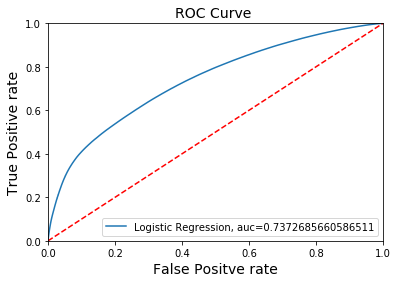

AUC: 0.7372685660586511


In [42]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_LR = model_LR.predict_proba(X_val)[::,1]
fpr_LR, tpr_LR, _ = metrics.roc_curve(y_val,  y_pred_proba_LR)
auc_LR = metrics.roc_auc_score(y_val, y_pred_proba_LR)
#plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr_LR,tpr_LR,label="Logistic Regression, auc="+str(auc_LR))
plt.legend(loc=4)
#plt.show()

#skplt.metrics.plot_roc_curve(fpr, tpr)
#plt.show()

##################################

#y_true = # true labels
#y_probas = # predicted results
#fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas, pos_label=0)
#roc_auc = auc(fpr, tpr)
#roc_label = '{} (AUC={:.3f})'.format(label, roc_auc)

# Print ROC curve
#print ('ROC curve')
plt.xlabel("False Positve rate", fontsize=14)
plt.ylabel("True Positive rate", fontsize=14)
plt.title("ROC Curve ", fontsize=14)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.plot(fpr,tpr,dpi =300)
plt.show() 

# Print AUC
auc_LR = np.trapz(tpr_LR,fpr_LR)
print('AUC:', auc_LR)

##2- Random Forest

In [43]:
# TRAIN 80% - VALIDATE 20% 

##########################
##IMPORT REQUIRED PACKAGES
##########################
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split #validate algorithm
from sklearn.metrics import f1_score, classification_report, confusion_matrix

##############################################################
## SPLIT DF TO: 80% for training and 20% as validation (axis=0) 
## & THEN TO to X_train, X_val, y_train, y_val (axis=1)
##############################################################
X_train, X_val, y_train, y_val = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered, test_size=0.8, random_state=42)

##########################
## INITIATE AND TRAIN MODEL
##########################
rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1 ,random_state=42)
model = rfc.fit(X_train, y_train) #

#####################################
## SCORE MODEL ON VALIDATION SET
#####################################
### Predict on validation set with fixed threshold

y_val_pred = (model.predict_proba(X_val)[:,1] >= 0.30).astype(int)

### Get scores on validation set
print("RESULTS ON VALIDATION SET\n====================")
print("F1 Score: ",f1_score(y_val, y_val_pred, average='binary'), "\n====================")
print("Classification Report\n ", classification_report(y_val, y_val_pred), "\n====================")
print("Confusion Matrix\n ", confusion_matrix(y_val, y_val_pred))

### Remove validate algorithm objects
#del [X_val, y_val]

RESULTS ON VALIDATION SET
F1 Score:  0.3512132655757067 
Classification Report
                precision    recall  f1-score   support

         0.0       0.93      0.89      0.91   6116209
         1.0       0.30      0.43      0.35    663520

    accuracy                           0.85   6779729
   macro avg       0.62      0.66      0.63   6779729
weighted avg       0.87      0.85      0.86   6779729
 
Confusion Matrix
  [[5453548  662661]
 [ 381026  282494]]


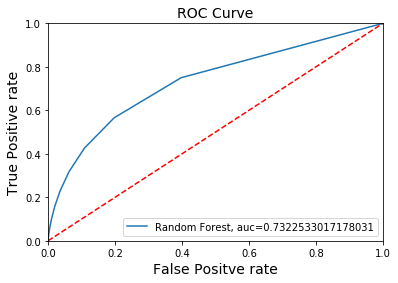

AUC: 0.7322533017178031


In [44]:
#####################for RF
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

#from sklearn import metrics
y_pred_proba_rf = rfc.predict_proba(X_val)[::,1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_val,  y_pred_proba_rf)
auc_rf = metrics.roc_auc_score(y_val, y_pred_proba_rf)
#plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr_rf,tpr_rf,label="Random Forest, auc="+str(auc_rf))
plt.legend(loc=4)
#plt.show()

#skplt.metrics.plot_roc_curve(fpr, tpr)
#plt.show()

##################################

#y_true = # true labels
#y_probas = # predicted results
#fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas, pos_label=0)
#roc_auc = auc(fpr, tpr)
#roc_label = '{} (AUC={:.3f})'.format(label, roc_auc)

# Print ROC curve
#print ('ROC curve')
plt.xlabel("False Positve rate", fontsize=14)
plt.ylabel("True Positive rate", fontsize=14)
plt.title("ROC Curve", fontsize=14)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.plot(fpr,tpr,dpi =300)
plt.show() 

# Print AUC
auc_rf = np.trapz(tpr_rf,fpr_rf)
print('AUC:', auc_rf)


##2 - XGBOOST

In [0]:
# TRAIN FULL 
###########################
## IMPORT REQUIRED PACKAGES
###########################
import xgboost as xgb

##########################################
## SPLIT DF TO: X_train, y_train (axis=1)
##########################################
#X_train, y_train = data_train.drop('reordered', axis=1), data_train.reordered

########################################
## SET BOOSTER'S PARAMETERS
########################################
parameters = {'eval_metric':'logloss', 
              'max_depth':'5', 
              'colsample_bytree':'0.4',
              'subsample':'0.75'
             }

########################################
## INSTANTIATE XGBClassifier()
########################################
xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)

########################################
## TRAIN MODEL
########################################
modelxgb = xgbc.fit(X_train, y_train)

#prediction
y_pred = (modelxgb.predict_proba(X_val)[:, 1] >= 0.21).astype('int') #setting a threshold.


In [0]:
from sklearn.metrics import f1_score, classification_report
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.classifiers import plot_feature_importances

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Result on Validation set for XGBoost
F1 Score: 0.4175960519066864
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93   6116209
         1.0       0.37      0.48      0.42    663520

    accuracy                           0.87   6779729
   macro avg       0.66      0.69      0.67   6779729
weighted avg       0.89      0.87      0.88   6779729

Confusion Matrix
[[5583415  532794]
 [ 347813  315707]]


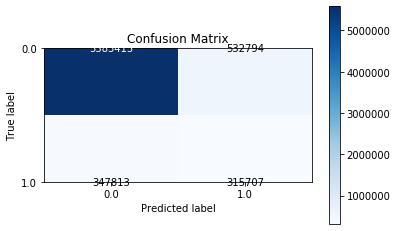

In [0]:
#Evaluation.
print('Result on Validation set for XGBoost')
print('=================================================')
print('F1 Score: {}'.format(f1_score(y_val, y_pred, average='binary')))
print('=================================================')
print(classification_report(y_val, y_pred))

print('=================================================')
print('Confusion Matrix')
cm = metrics.confusion_matrix(y_val, y_pred)
print(cm)

plot_confusion_matrix(y_val, y_pred)

### Get scores on validation set
#print("RESULTS ON VALIDATION SET\n====================")
#print("F1 Score: ",f1_score(y_val, y_val_pred, average='binary'), "\n====================")
#print("Classification Report\n ", classification_report(y_val, y_val_pred), "\n====================")
#print("Confusion Matrix\n ", confusion_matrix(y_val, y_pred))


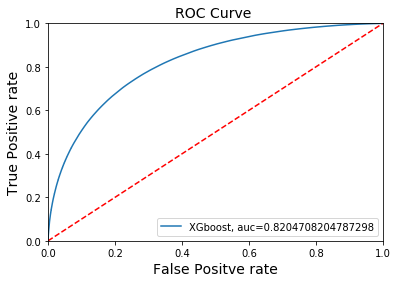

AUC: 0.8204708204787298


In [0]:
#####################for XGB

y_pred_proba_xgb = xgbc.predict_proba(X_val)[::,1]
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_val,  y_pred_proba_xgb)
auc_xgb = metrics.roc_auc_score(y_val, y_pred_proba_xgb)
#plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr_xgb,tpr_xgb,label="XGboost, auc="+str(auc_xgb))
plt.legend(loc=4)
#plt.show()

#skplt.metrics.plot_roc_curve(fpr, tpr)
#plt.show()

##################################

#y_true = # true labels
#y_probas = # predicted results
#fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas, pos_label=0)
#roc_auc = auc(fpr, tpr)
#roc_label = '{} (AUC={:.3f})'.format(label, roc_auc)

# Print ROC curve
#print ('ROC curve')
plt.xlabel("False Positve rate", fontsize=14)
plt.ylabel("True Positive rate", fontsize=14)
plt.title("ROC Curve ", fontsize=14)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.plot(fpr,tpr,dpi =300)
plt.show() 

# Print AUC
auc_xgb = np.trapz(tpr_xgb,fpr_xgb)
print('AUC:', auc_xgb)

# 5. Apply predictive model (predict)
The model that we have created is stored in the **model** object.
At this step we predict the values for the test data and we store them in a new column in the same DataFrame.

In [45]:
# Predict values for test data with our model from chapter 5 - the results are saved as a Python array
test_pred = model.predict(data_test).astype(int)
test_pred[0:20] #display the first 20 predictions of the numpy array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [46]:
## OR set a custom threshold (in this problem, 0.21 yields the best prediction)
test_pred = (model.predict_proba(data_test)[:,1] >= 0.21).astype(int)
test_pred[0:20] #display the first 20 predictions of the numpy array

array([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0])

In [47]:
#Save the prediction (saved in a numpy array) on a new column in the data_test DF
data_test['prediction'] = test_pred
data_test.head(10)

user_b_prod_total_bought  ...  prediction
user_id product_id                            ...            
3       248                                1  ...           0
        1005                               1  ...           1
        1819                               3  ...           1
        7503                               1  ...           1
        8021                               1  ...           0
        9387                               5  ...           1
        12845                              1  ...           0
        14992                              2  ...           0
        15143                              1  ...           0
        16797                              3  ...           1

[10 rows x 7 columns]

In [49]:
#Reset the index
final = data_test.reset_index()
#Keep only the required columns to create our submission file (for chapter 6)
final = final[['product_id', 'user_id', 'prediction']]

gc.collect()
final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,1
2,1819,3,1
3,7503,3,1
4,8021,3,0


#Getting the Final Result

In [50]:
orders_test = orders.loc[orders.eval_set=='test',("user_id", "order_id") ]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [51]:
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,1,2774568
2,1819,3,1,2774568
3,7503,3,1,2774568
4,8021,3,0,2774568


And we move on with two final manipulations:
- remove any undesired column (in our case user_id)

In [0]:
#remove user_id column
final = final.drop('user_id', axis=1)


- set product_id column as integer (mandatory action to proceed to the next step)

In [53]:
#convert product_id as integer
final['product_id'] = final.product_id.astype(int)

## Remove all unnecessary objects
del orders
del orders_test
gc.collect()

final.head()

,product_id,prediction,order_id
0,248,0,2774568
1,1005,1,2774568
2,1819,1,2774568
3,7503,1,2774568
4,8021,0,2774568


We convert the dictionary to a DataFrame and prepare it to extact it into a .csv file

In [54]:
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'
        
gc.collect()

#We now check how the dictionary were populated (open hidden output)
d

{2774568: '1005 1819 7503 9387 16797 18599 21903 22035 39190 43961 47766',
 329954: '19057 25623',
 1528013: '8424 10644 21903 27521',
 1376945: '8309 14947 20383 27959 38456 42585 43352',
 1356845: '5876 7076 14992 19006 38164 42450 44422 47672 48364',
 2161313: '196 11266 12427',
 1416320: '5134 15872 17948 21137 21903 24852 28199 28985 32691 41950 44359',
 1735923: '196 1832 7559 9387 15599 21011 31487 43409 48437',
 1980631: '6184 9387 13575 13914 22362 41400 46061',
 139655: '5450 13176 21903 22935 22963 24506 27845 39040',
 1411408: '22008 43758',
 2940603: '4091 7355 10339 14947 19894 31615',
 1192143: '8424 8615 21903 23044 49236',
 280888: '19213 27086 28647 44375',
 3202221: '4793 5612 6187 7781 9637 10831 13049 20168 21137 24852 27966 37646 40706 42342 45364 46979 49175 49215',
 3222866: '8501 13187 15718 18894 32441 33198 34254 35921 38690 40706 42441 47145 49680',
 707453: '694 4942 6111 8518 18150 20734 21137 21267 21903 25826 28156 28842 32030 39275 42585 44830 45066 482

In [55]:
#Convert the dictionary into a DataFrame
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,2774568,1005 1819 7503 9387 16797 18599 21903 22035 39...
1,329954,19057 25623
2,1528013,8424 10644 21903 27521
3,1376945,8309 14947 20383 27959 38456 42585 43352
4,1356845,5876 7076 14992 19006 38164 42450 44422 47672 ...
